# Metrics Aggregation by Experiment
This notebook aggregates metrics from all_metrics.csv by experiment name,
showing mean and standard deviation for coverage, mutation score, and tokens used.

# Graphs for the report

Temperature Sensitivity Analysis: Single Agent Llama 8B
 temperature  pass_rate  coverage_percent  mutation_score_percent  total_tokens  iterations
         0.0  61.424774         99.052632               82.896316    632.684211         0.0
         0.2  56.996032         96.000000               74.581500    692.550000         0.0
         0.4  61.501443         90.550000               69.610000    666.850000         0.0
         0.6  62.617424         89.900000               73.468000    653.300000         0.0
         0.8  57.986541         93.150000               66.257500    739.150000         0.0
         1.0  47.245625         90.222222               75.699444    698.277778         0.0
         1.2  54.420394         89.222222               61.170000    712.666667         0.0




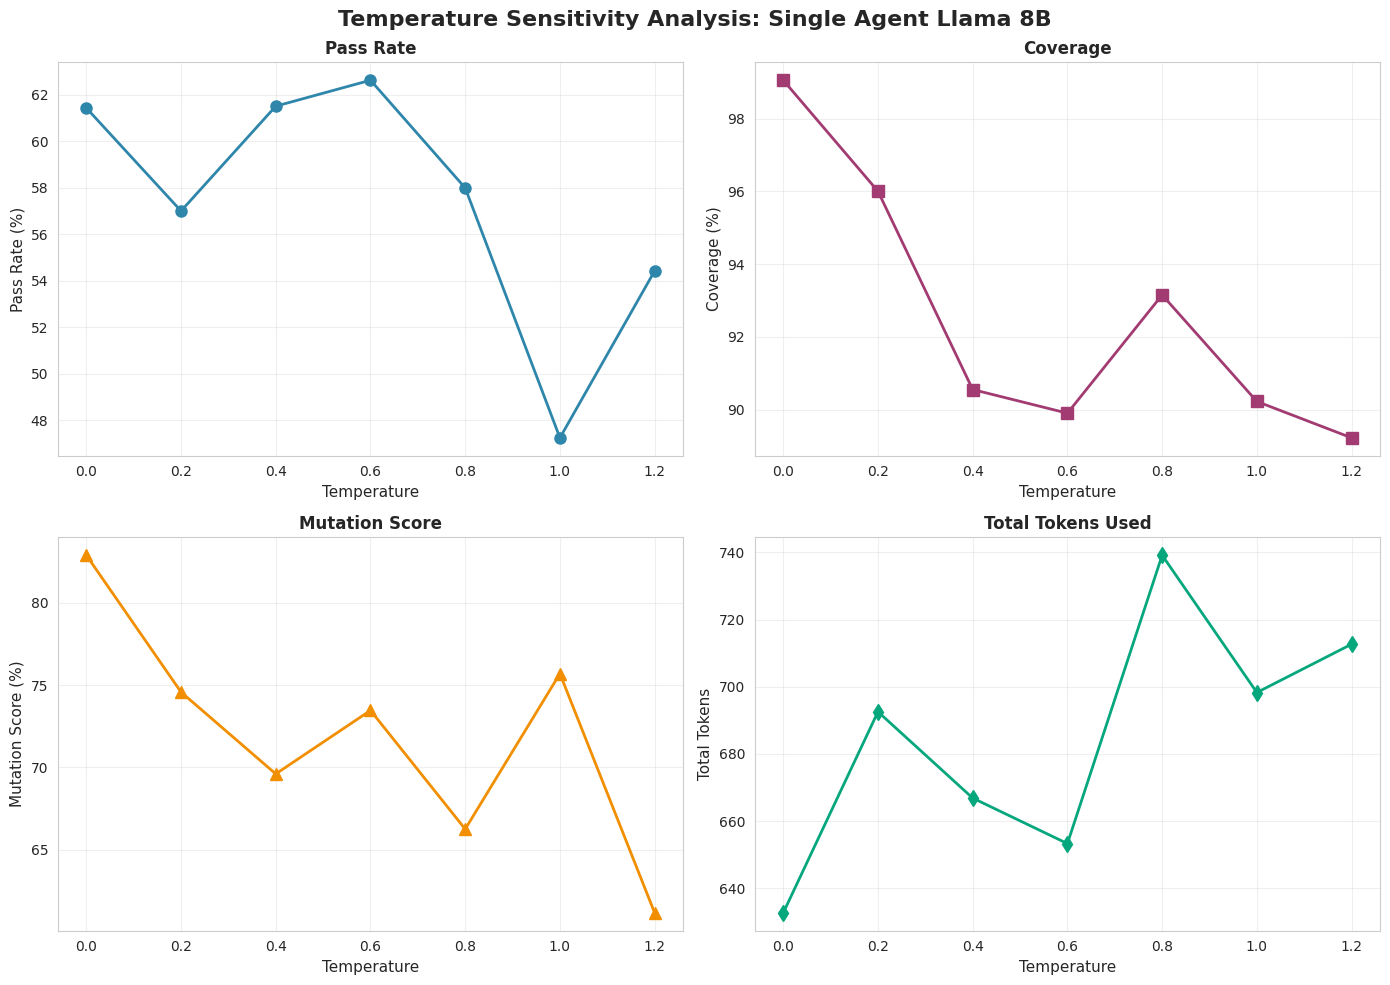

In [55]:
# Aggregate Single Agent Llama 8B by Temperature
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] == "success"]

# Filter Single Agent Llama 8B runs
df_llama8b = df[
    df["experiment_name"].str.contains("ablative_single_llama8B", na=False)
].copy()

# Calculate Metrics
df_llama8b["total_tests"] = df_llama8b["n_passed_tests"] + df_llama8b["n_failed_tests"]
df_llama8b["pass_rate"] = df_llama8b.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)

# Group by temperature and aggregate
metrics = [
    "pass_rate",
    "coverage_percent",
    "mutation_score_percent",
    "total_tokens",
    "iterations",
]
agg_by_temp = df_llama8b.groupby("temperature")[metrics].mean().reset_index()

# Display aggregated data
print("Temperature Sensitivity Analysis: Single Agent Llama 8B")
print("=" * 80)
print(agg_by_temp.to_string(index=False))
print("\n")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    "Temperature Sensitivity Analysis: Single Agent Llama 8B",
    fontsize=16,
    fontweight="bold",
)

# Plot 1: Pass Rate
axes[0, 0].plot(
    agg_by_temp["temperature"],
    agg_by_temp["pass_rate"],
    marker="o",
    linewidth=2,
    markersize=8,
    color="#2E86AB",
)
axes[0, 0].set_xlabel("Temperature", fontsize=11)
axes[0, 0].set_ylabel("Pass Rate (%)", fontsize=11)
axes[0, 0].set_title("Pass Rate", fontsize=12, fontweight="bold")
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Coverage
axes[0, 1].plot(
    agg_by_temp["temperature"],
    agg_by_temp["coverage_percent"],
    marker="s",
    linewidth=2,
    markersize=8,
    color="#A23B72",
)
axes[0, 1].set_xlabel("Temperature", fontsize=11)
axes[0, 1].set_ylabel("Coverage (%)", fontsize=11)
axes[0, 1].set_title("Coverage", fontsize=12, fontweight="bold")
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Mutation Score
axes[1, 0].plot(
    agg_by_temp["temperature"],
    agg_by_temp["mutation_score_percent"],
    marker="^",
    linewidth=2,
    markersize=8,
    color="#F18F01",
)
axes[1, 0].set_xlabel("Temperature", fontsize=11)
axes[1, 0].set_ylabel("Mutation Score (%)", fontsize=11)
axes[1, 0].set_title("Mutation Score", fontsize=12, fontweight="bold")
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Total Tokens
axes[1, 1].plot(
    agg_by_temp["temperature"],
    agg_by_temp["total_tokens"],
    marker="d",
    linewidth=2,
    markersize=8,
    color="#06A77D",
)
axes[1, 1].set_xlabel("Temperature", fontsize=11)
axes[1, 1].set_ylabel("Total Tokens", fontsize=11)
axes[1, 1].set_title("Total Tokens Used", fontsize=12, fontweight="bold")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Collaborative vs Collaborative Var vs Competitive

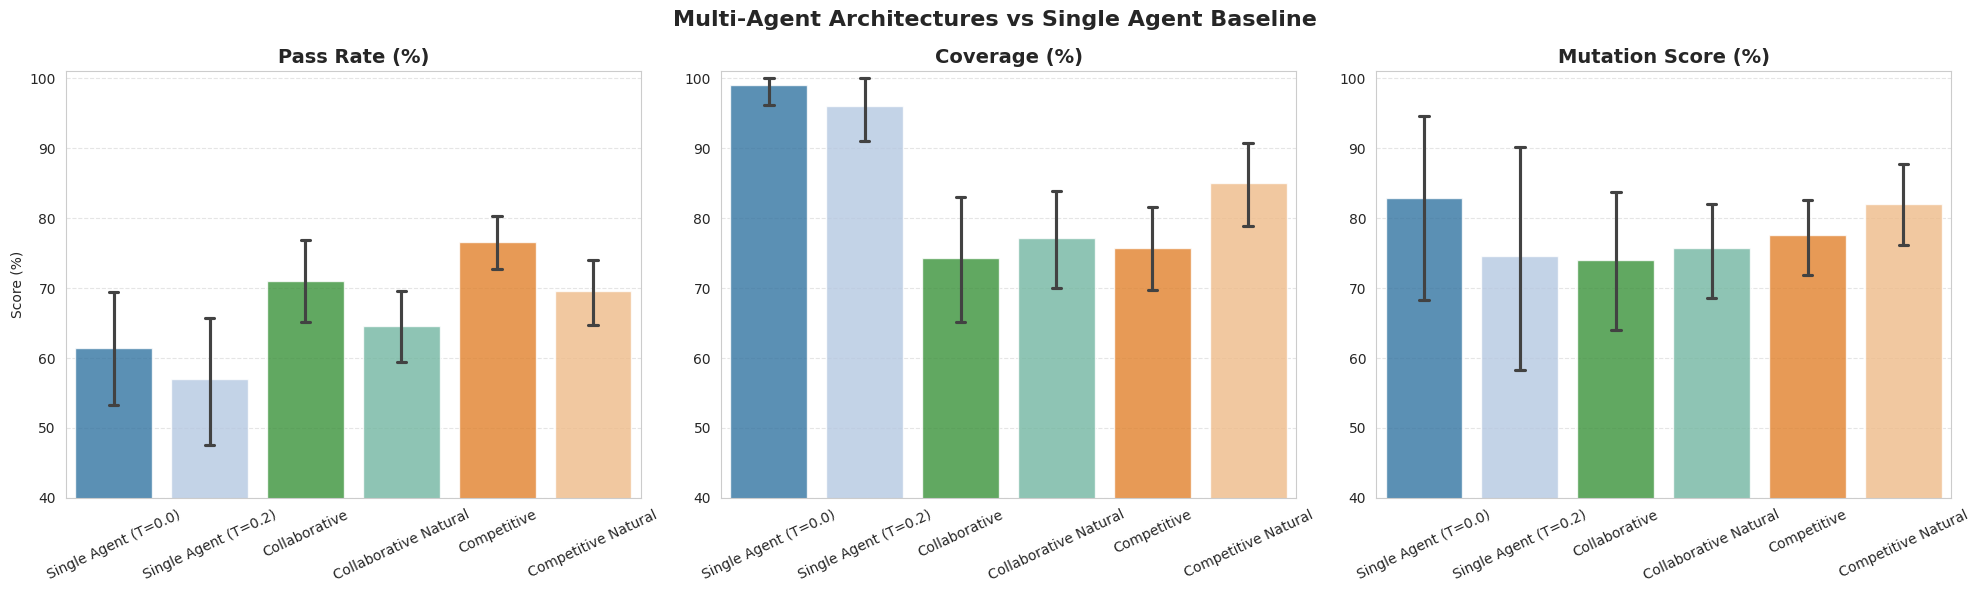


Summary Statistics:
                      pass_rate              coverage_percent               \
                           mean    std count             mean    std count   
Category                                                                     
Collaborative             71.02  25.48    69            74.28  39.56    69   
Collaborative Natural     64.58  28.22   117            77.10  38.54   117   
Competitive               76.58  27.11   190            75.72  40.43   190   
Competitive Natural       69.63  25.42   114            85.01  32.83   114   
Single Agent (T=0.0)      61.42  18.59    19            99.05   4.13    19   
Single Agent (T=0.2)      57.00  21.58    20            96.00  10.07    20   

                      mutation_score_percent               
                                        mean    std count  
Category                                                   
Collaborative                          58.97  44.31    69  
Collaborative Natural               

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv("all_metrics.csv")

# Filter out failed runs
df = df[df["status"] == "success"]

# Filter out runs where no tests passed
# df = df[df["n_passed_tests"] > 0]

# Filter experiments: collaborative, competitive, and single llama8B T=0.0 and T=0.2
df_filtered = df[
    df["experiment_name"].str.contains(
        "collaborative_llama8B|competitive_llama8B|ablative_single_llama8B_t=0.2|ablative_single_llama8B_t=0.0",
        regex=True,
        na=False,
    )
].copy()


# Calculate Pass Rate
df_filtered["total_tests"] = (
    df_filtered["n_passed_tests"] + df_filtered["n_failed_tests"]
)

df_filtered = df_filtered[df_filtered["total_tests"] > 0]

df_filtered["pass_rate"] = df_filtered.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)

mask_trivial = (df_filtered["coverage_percent"] < 5) & (df_filtered["pass_rate"] > 90)
df_filtered = df_filtered[~mask_trivial]


# Create Category Labels
def categorize_experiment(exp_name):
    if "single_llama8B_t=0.0" in exp_name:
        return "Single Agent (T=0.0)"
    elif "single_llama8B_t=0.2" in exp_name:
        return "Single Agent (T=0.2)"
    elif "collaborative_llama8B_natural" in exp_name:
        return "Collaborative Natural"
    elif "collaborative_llama8B_json" in exp_name or (
        "collaborative_llama8B" in exp_name
        and "_json" not in exp_name
        and "_natural" not in exp_name
    ):
        return "Collaborative"
    elif "competitive_llama8B_natural" in exp_name:
        return "Competitive Natural"
    elif "competitive_llama8B_json" in exp_name or (
        "competitive_llama8B" in exp_name
        and "_json" not in exp_name
        and "_natural" not in exp_name
    ):
        return "Competitive"
    return "Other"


df_filtered["Category"] = df_filtered["experiment_name"].apply(categorize_experiment)

# Remove any "Other" category if present
df_filtered = df_filtered[df_filtered["Category"] != "Other"]

# Define Colors
COLORS = {
    "Single Agent (T=0.0)": "#1f77b4",
    "Single Agent (T=0.2)": "#aec7e8",
    "Collaborative": "#2ca02c",
    "Collaborative Natural": "#66c2a5",
    "Competitive": "#ff7f0e",
    "Competitive Natural": "#ffbb78",
}

# Metrics to plot
metrics = [
    ("pass_rate", "Pass Rate (%)", 40, 101),
    ("coverage_percent", "Coverage (%)", 40, 101),
    ("mutation_score_percent", "Mutation Score (%)", 40, 101),
]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle(
    "Multi-Agent Architectures vs Single Agent Baseline", fontsize=16, fontweight="bold"
)

category_order = [
    "Single Agent (T=0.0)",
    "Single Agent (T=0.2)",
    "Collaborative",
    "Collaborative Natural",
    "Competitive",
    "Competitive Natural",
]

for i, (metric, title, ylim_min, ylim_max) in enumerate(metrics):
    ax = axes[i]

    # Apply mutation filter only for mutation_score_percent
    if metric == "mutation_score_percent":
        df_plot = df_filtered[
            (df_filtered["mutation_killed"] + df_filtered["mutation_survived"]) > 0
        ]
    else:
        df_plot = df_filtered

    # Plot bars with 95% confidence intervals
    sns.barplot(
        data=df_plot,
        x="Category",
        y=metric,
        hue="Category",
        order=category_order,
        hue_order=category_order,
        palette=COLORS,
        ax=ax,
        errorbar=("ci", 95),  # 95% confidence interval
        capsize=0.1,
        alpha=0.8,
        legend=False,
    )

    # Styling
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_ylim(ylim_min, ylim_max)
    ax.set_ylabel("Score (%)" if i == 0 else "")
    ax.set_xlabel("")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Rotate x-axis labels for better readability
    ax.tick_params(axis="x", rotation=25)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 80)
summary = df_filtered.groupby("Category")[
    ["pass_rate", "coverage_percent", "mutation_score_percent"]
].agg(["mean", "std", "count"])
print(summary.round(2))

## Efficiency Comparison: 4 Variants

/tmp/ipykernel_16475/1763991222.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


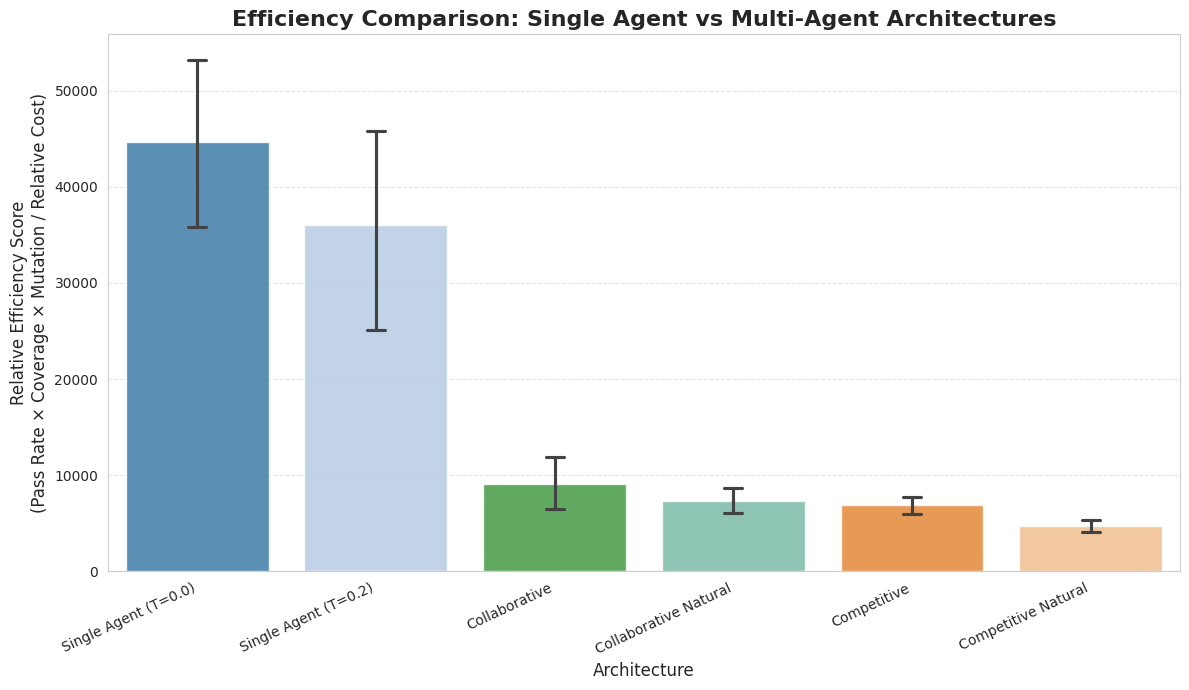


Efficiency Statistics:
                           mean       std  count
Category                                        
Collaborative           9071.77  11682.03     69
Collaborative Natural   7332.96   6914.17    109
Competitive             6873.77   6478.99    186
Competitive Natural     4690.06   3467.37    110
Single Agent (T=0.0)   44618.03  20329.80     19
Single Agent (T=0.2)   36010.98  24003.29     20


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] == "success"]

# Filter out runs where no tests passed
df = df[df["n_passed_tests"] > 0]

# Filter experiments: collaborative, competitive, and single llama8B T=0.0 and T=0.2
df_filtered = df[
    df["experiment_name"].str.contains(
        "collaborative_llama8B|competitive_llama8B|ablative_single_llama8B_t=0.0|ablative_single_llama8B_t=0.2",
        regex=True,
        na=False,
    )
].copy()

# Calculate Pass Rate
df_filtered["total_tests"] = (
    df_filtered["n_passed_tests"] + df_filtered["n_failed_tests"]
)

df_filtered = df_filtered[df_filtered["total_tests"] > 0]

df_filtered["pass_rate"] = df_filtered.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] if row["total_tests"] > 0 else 0
    ),
    axis=1,
)

mask_trivial = (df_filtered["coverage_percent"] < 5) & (df_filtered["pass_rate"] > 90)
df_filtered = df_filtered[~mask_trivial]

# File-Normalized Tokens (Relative Cost)
file_mean_tokens = df_filtered.groupby("file")["total_tokens"].transform("mean")
df_filtered["tokens_relative_cost"] = df_filtered["total_tokens"] / file_mean_tokens

# Relative Efficiency Score = (Quality / Cost)
# Quality = PassRate * Coverage * Mutation
# Cost = Normalized Tokens
df_filtered["efficiency"] = (
    df_filtered["pass_rate"]
    * df_filtered["coverage_percent"]
    * df_filtered["mutation_score_percent"]
    / df_filtered["tokens_relative_cost"]
)


# Create Category Labels
def categorize_experiment(exp_name):
    if (
        "ablative_single_llama8B_t=0.0" in exp_name
        or "single_llama8B_t=0.0" in exp_name
    ):
        return "Single Agent (T=0.0)"
    elif (
        "ablative_single_llama8B_t=0.2" in exp_name
        or "single_llama8B_t=0.2" in exp_name
    ):
        return "Single Agent (T=0.2)"
    elif "collaborative_llama8B_natural" in exp_name:
        return "Collaborative Natural"
    elif "collaborative_llama8B_json" in exp_name or (
        "collaborative_llama8B" in exp_name
        and "_json" not in exp_name
        and "_natural" not in exp_name
    ):
        return "Collaborative"
    elif "competitive_llama8B_natural" in exp_name:
        return "Competitive Natural"
    elif "competitive_llama8B_json" in exp_name or (
        "competitive_llama8B" in exp_name
        and "_json" not in exp_name
        and "_natural" not in exp_name
    ):
        return "Competitive"
    return "Other"


df_filtered["Category"] = df_filtered["experiment_name"].apply(categorize_experiment)

# Remove any "Other" category if present
df_filtered = df_filtered[df_filtered["Category"] != "Other"]

# Define Colors
COLORS = {
    "Single Agent (T=0.0)": "#1f77b4",
    "Single Agent (T=0.2)": "#aec7e8",
    "Collaborative": "#2ca02c",
    "Collaborative Natural": "#66c2a5",
    "Competitive": "#ff7f0e",
    "Competitive Natural": "#ffbb78",
}

# Plotting
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

category_order = [
    "Single Agent (T=0.0)",
    "Single Agent (T=0.2)",
    "Collaborative",
    "Collaborative Natural",
    "Competitive",
    "Competitive Natural",
]

ax = sns.barplot(
    data=df_filtered,
    x="Category",
    y="efficiency",
    order=category_order,
    palette=COLORS,
    errorbar=("ci", 95),  # 95% Confidence Interval
    capsize=0.1,
    alpha=0.8,
)

plt.title(
    "Efficiency Comparison: Single Agent vs Multi-Agent Architectures",
    fontsize=16,
    fontweight="bold",
)
plt.ylabel(
    "Relative Efficiency Score\n(Pass Rate × Coverage × Mutation / Relative Cost)",
    fontsize=12,
)
plt.xlabel("Architecture", fontsize=12)
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5, which="both")
plt.tight_layout()
plt.show()

# Print efficiency statistics
print("\nEfficiency Statistics:")
print("=" * 80)
efficiency_summary = df_filtered.groupby("Category")["efficiency"].agg(
    ["mean", "std", "count"]
)
print(efficiency_summary.round(2))